In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from functions import text_utils ,utils,classification_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
import logging



logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

random_state=42

# Partie 1: <u>Analyse exploiratoire, nettoyage description</u>

## 1 <u>Exploration des donnée</u>

In [3]:
df=pd.read_csv('data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [4]:
df.shape

(1050, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

L'objet de projet étant de classer un produit en fonction de l'image fournie et de la description,nous nous intéressons uniquement aux variables catégorie,image

In [7]:
relevant_cols = ['uniq_id','product_category_tree','description','product_url']
df=df[relevant_cols]

Vérification des doublons à l'aide de la variable uniq_id

In [8]:
len(df.loc[df.duplicated(subset='uniq_id',keep='first')]) ## 0 aucun doublons

0

In [9]:
df.isnull().sum()/len(df)*100 ## aucune valeur manquante

uniq_id                  0.0
product_category_tree    0.0
description              0.0
product_url              0.0
dtype: float64

In [10]:

def get_main_category_by_depth(txt,depth=0):
    "fonction permettant de récupérer la catégorie en fonction de la profondeur, par défaut elle récupère"
    return txt.split("\"")[1].split('>>')[depth].rstrip()
    

In [11]:
df['main_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,0))
df['second_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,1))
#df['third_category']=df['product_category_tree'].apply(lambda x:get_main_category_by_depth(x,2))


In [12]:
## aucune valeur manquante
df.isnull().sum()/len(df)*100

uniq_id                  0.0
product_category_tree    0.0
description              0.0
product_url              0.0
main_category            0.0
second_category          0.0
dtype: float64

In [13]:
#df['main_category'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
df['main_category'].value_counts(normalize=True)

Kitchen & Dining              0.142857
Home Decor & Festive Needs    0.142857
Home Furnishing               0.142857
Beauty and Personal Care      0.142857
Watches                       0.142857
Computers                     0.142857
Baby Care                     0.142857
Name: main_category, dtype: float64

In [14]:
category_percent=df['main_category'].value_counts(normalize=True).reset_index().rename(columns={'index': 'names'})
px.pie(category_percent, values='main_category', names='names', title='Diagramme à secteurs des catégories de produits').show()


Les catégories racines des produits sont égalitairement bien réparties

## 2 <u>Encodage de la variable cible (labelEncoder)</u>

In [15]:

label_target_encoder=LabelEncoder()
df['target']=label_target_encoder.fit_transform(df['main_category'])


## 3 <u>preprocessing de la variable description</u>

In [16]:
## letttre un commentaire de ce que la fonction fait
df['description_transform_bow_fct']=df['description'].apply(lambda x: text_utils.transform_bow_fct(x))

In [17]:
df[['description_transform_bow_fct']].head()

description_transform_bow_fct
0  key features elegance polyester multicolor abs...
1  specifications sathiyas cotton bath towel bath...
2  key features eurospa cotton terry face towel s...
3  key features santosh royal fashion cotton prin...
4  key features jaipur print cotton floral king s...

# Partie 2: <u>Traitement textuel NLP</u>

## 1 <u>Simple bag of words</u>

### 1-1 <u>Transformation de la description avec CountVectorizer </u>

In [18]:
countVectorizer = CountVectorizer()
bag_of_words_vec =countVectorizer.fit_transform(df['description_transform_bow_fct'])
bag_of_words_df=pd.DataFrame(bag_of_words_vec.toarray(),columns=countVectorizer.get_feature_names_out())

In [19]:
bag_of_words_df.shape

(1050, 5894)

In [20]:
bag_of_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Columns: 5894 entries, 000 to zyxel
dtypes: int64(5894)
memory usage: 47.2 MB


In [21]:
bag_of_words_df.head()

000  001  0021  004  005  006  0083  011  01433cmgy  01727lpln  ...  zinc  \
0    0    0     0    0    0    0     0    0          0          0  ...     0   
1    0    0     0    0    0    0     0    0          0          0  ...     0   
2    0    0     0    0    0    0     0    0          0          0  ...     0   
3    0    0     0    0    0    0     0    0          0          0  ...     0   
4    0    0     0    0    0    0     0    0          0          0  ...     0   

   zingalalaa  zip  zipexterior  zipper  zippered  zone  zoom  zora  zyxel  
0           0    0            0       0         0     0     0     0      0  
1           0    0            0       0         0     0     0     0      0  
2           0    0            0       0         0     0     0     0      0  
3           0    0            0       0         0     0     0     0      0  
4           0    0            0       0         0     0     0     0      0  

[5 rows x 5894 columns]

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.4034 time :  7.0


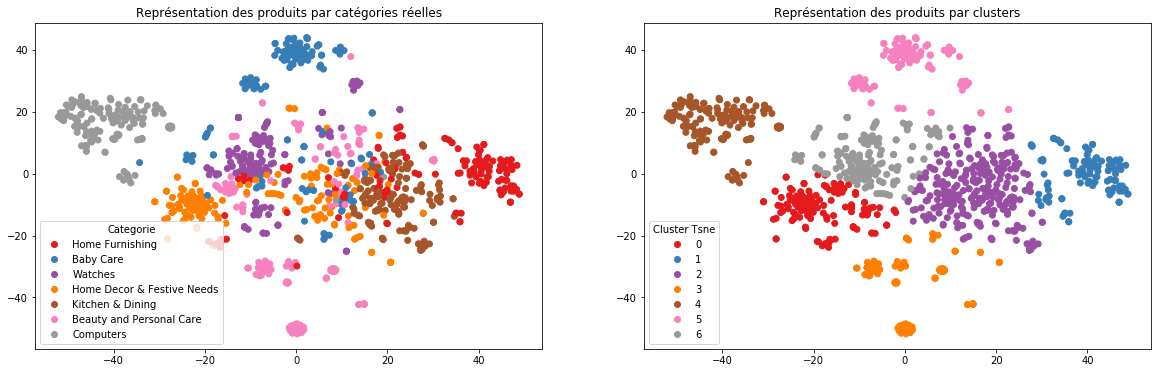

ARI :  0.4034


In [22]:

all_labels=df['target'].unique().tolist()
perplexity=30

n_components=2
ARI, X_tsne, labels =text_utils.ARI_fct(
    bag_of_words_df,
    all_labels,
    df['target'],
    perplexity,
    n_components,
    random_state
  
)

text_utils.TSNE_visu_fct(
    X_tsne, df['target'],df['main_category'].unique().tolist(), labels, ARI,
  'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters'
)

L'indice de rand ajusté (0.35) entre l'ensemble issu de la clusterization tsne et l'ensemble formé par les catégories réelles auxquelles appartiennent les produits, est très faible.
Cependant,on peut remarquer, selon le résultat du tsne, une plus ou moins bonne segmentation des produits de catégorie Computers,Home Furnishing et Baby Care

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X_tsne,df['target'],test_size=0.25)
scoring='f1_macro'
 

param_grid =[
     { 
   # 'estimator__n_estimators': [100], #[200, 500]
    #'estimator__max_features': ['auto'],#['auto', 'sqrt', 'log2']
    #'estimator__max_depth' : [5],#[4,5,6,7,8]
   'estimator__criterion' :  ['gini', 'entropy'],
         'estimator__random_state':[random_state]
}
]
 
cv=3
model=OneVsRestClassifier(RandomForestClassifier())
mean_auc,ARI,_=classification_utils.grid_search_cv_multiclass(
    model,
    param_grid,
    scoring,
    cv,
    label_target_encoder,
    df['main_category'].unique().tolist(),
    X_train,
    X_test,
    y_train,
    y_test,
'catégories réelles l\'échantillon de test des produits',
  'catégories prédites l\'échantillon de test des produits',
    'Classification OneVsRestClassifier(RandomForestClassifier())'
)


/home/amadou/Desktop/ml/classification_automatique_biens_consommation/functions/text_utils.py:108: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



ARI :  0.687
ARI 0.687
mean_auc 0.9755866054081656


In [24]:
mean_auc

0.9755866054081656

le résultat de la classification, après une réduction dimensionnelle tsne, semble être un bon score(97% la moyenne ).Plus particulièrement pour les produits de catégorie Watches (100% de Area Under the curve)

## 2 <u>TF-IDF</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer()

bag_of_words_vec =tfidfVectorizer.fit_transform(df['description_transform_bow_fct'])
bag_of_words_df=pd.DataFrame(bag_of_words_vec.toarray(),columns=tfidfVectorizer.get_feature_names_out())


In [26]:
bag_of_words_df.shape

(1050, 5894)

In [27]:
bag_of_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Columns: 5894 entries, 000 to zyxel
dtypes: float64(5894)
memory usage: 47.2 MB


In [28]:
bag_of_words_df.head()

000  001  0021  004  005  006  0083  011  01433cmgy  01727lpln  ...  zinc  \
0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   0.0   
1  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   0.0   
2  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   0.0   
3  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   0.0   
4  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   0.0   

   zingalalaa  zip  zipexterior  zipper  zippered  zone  zoom  zora  zyxel  
0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0    0.0  
1         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0    0.0  
2         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0    0.0  
3         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0    0.0  
4         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0    0.0  

[5 rows x 5894 columns]

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.4293 time :  5.0


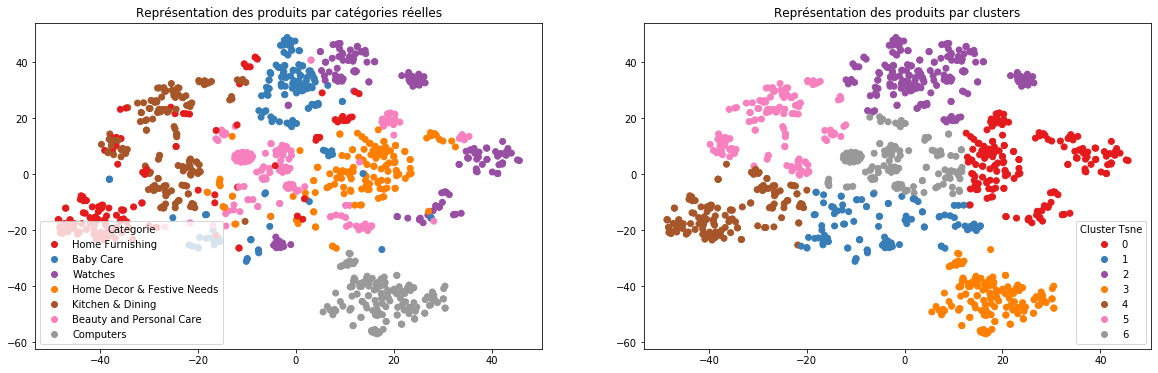

ARI :  0.4293


In [29]:

all_labels=df['target'].unique().tolist()
perplexity=30

n_components=2
ARI, X_tsne, labels =text_utils.ARI_fct(
    bag_of_words_df,
    all_labels,
    df['target'],
    perplexity,
    n_components,
    random_state
  
)

text_utils.TSNE_visu_fct(
    X_tsne, df['target'],df['main_category'].unique().tolist(), labels, ARI,
  'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters'
)

L'indice de rand ajusté (0.50) entre l'ensemble issu de la clusterization tsne et l'ensemble formé par les catégories réelles auxquelles appartiennent les produits, est très faible.
Cependant,on peut remarquer, selon le résultat du tsne, une plus ou moins bonne segmentation des produits de catégorie Computers,Home Furnishing,Home Decors & Festive Needs 

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X_tsne,df['target'],test_size=0.25)
scoring='f1_macro'
 

param_grid =[
     { 
   # 'estimator__n_estimators': [100], #[200, 500]
    #'estimator__max_features': ['auto'],#['auto', 'sqrt', 'log2']
    #'estimator__max_depth' : [5],#[4,5,6,7,8]
   'estimator__criterion' :  ['gini', 'entropy'],
         'estimator__random_state':[random_state]
}
]
 
cv=3
model=OneVsRestClassifier(RandomForestClassifier())
mean_auc,ARI,_=classification_utils.grid_search_cv_multiclass(
    model,
    param_grid,
    scoring,
    cv,
    label_target_encoder,
    df['main_category'].unique().tolist(),
    X_train,
    X_test,
    y_train,
    y_test,
'Représentation des produits par catégories réelles',
    'Représentation des produits par clusters',
     'Classification OneVsRestClassifier(RandomForestClassifier())'
)


/home/amadou/Desktop/ml/classification_automatique_biens_consommation/functions/text_utils.py:108: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



ARI :  0.8206
ARI 0.8206
mean_auc 0.9934306792023972


## 3 <u>Word2Vec</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>


### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

## 4 <u>BERT</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>


### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>

## 5 <u>USE (Universal Sentence Encoder)</u>

### 1-1 <u>Transformation de la description avec TfidfVectorizer </u>

### 1-2 <u>Comparaison entre la clusterisation Tsne et les catégories réelles des produits </u>

### 1-3 <u>Essai de classification avec RandomForestClassifier  OneVsRestClassifier</u>